In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

In [4]:
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 313 kB 2.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [8]:
!pip install future

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 840 kB 4.2 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492037 sha256=6d3739dccb07cafed4831da389eee578622a0e5080180079c56ab3b451eaca16
  Stored in directory: /tmp/pip-ephem-wheel-cache-5o00j9rz/wheels/a0/0b/ee/e6994fadb42c1354dcccb139b0bf2795271bddfe6253ccdf11
Successfully built future
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [9]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../data/cifar-10-batches-py/'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [11]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.351428
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 



In [12]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 3.779734 analytic: 3.779734, relative error: 1.211217e-09
numerical: 1.131043 analytic: 1.131043, relative error: 1.363524e-08
numerical: -0.389687 analytic: -0.389687, relative error: 3.183323e-08
numerical: -0.274622 analytic: -0.274623, relative error: 1.609359e-07
numerical: -5.875839 analytic: -5.875839, relative error: 6.977252e-09
numerical: 1.046009 analytic: 1.046009, relative error: 3.951086e-08
numerical: 2.301136 analytic: 2.301136, relative error: 4.769620e-09
numerical: -0.274703 analytic: -0.274703, relative error: 4.245383e-08
numerical: 0.424016 analytic: 0.424016, relative error: 5.927077e-08
numerical: 0.920671 analytic: 0.920671, relative error: 5.542158e-08
numerical: 1.477948 analytic: 1.477948, relative error: 5.101976e-09
numerical: 0.735892 analytic: 0.735892, relative error: 2.296977e-08
numerical: -3.681200 analytic: -3.681200, relative error: 4.551289e-09
numerical: -7.681487 analytic: -7.681486, relative error: 5.636338e-09
numerical: 0.750183 an

In [13]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.351428e+00 computed in 0.108460s
vectorized loss: 2.351428e+00 computed in 0.239213s
Loss difference: 0.000000
Gradient difference: 0.000000


In [15]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
# learning_rates = [1e-7, 5e-7]
# regularization_strengths = [2.5e4, 5e4]
learning_rates = [1e-7, 1e-8, 1e-6, 5e7, 5e-8]
regularization_strengths = [2.5e4, 5e4, 1e5, 1e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        cls = Softmax()
        loss_hist = cls.train(X_train, y_train, learning_rate=lr, reg=reg,
                            num_iters=1000, verbose=True)
        
        y_train_pred = cls.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = cls.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)

        results[(lr, reg)] = (training_accuracy, validation_accuracy)

        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_softmax = cls
            # break

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 774.082183
iteration 100 / 1000: loss 283.901587
iteration 200 / 1000: loss 105.193895
iteration 300 / 1000: loss 39.815446
iteration 400 / 1000: loss 15.936589
iteration 500 / 1000: loss 7.136804
iteration 600 / 1000: loss 3.931204
iteration 700 / 1000: loss 2.812874
iteration 800 / 1000: loss 2.338471
iteration 900 / 1000: loss 2.179485
iteration 0 / 1000: loss 1539.597042
iteration 100 / 1000: loss 207.566623
iteration 200 / 1000: loss 29.593075
iteration 300 / 1000: loss 5.790205
iteration 400 / 1000: loss 2.600230
iteration 500 / 1000: loss 2.178710
iteration 600 / 1000: loss 2.185348
iteration 700 / 1000: loss 2.158724
iteration 800 / 1000: loss 2.187064
iteration 900 / 1000: loss 2.119173
iteration 0 / 1000: loss 3080.833974
iteration 100 / 1000: loss 56.135000
iteration 200 / 1000: loss 3.099436
iteration 300 / 1000: loss 2.213408
iteration 400 / 1000: loss 2.167362
iteration 500 / 1000: loss 2.212123
iteration 600 / 1000: loss 2.214670
iteration 700 / 

/tf_tutorials/pytorch/assignment1/cs231n/classifiers/softmax.py:98: RuntimeWarning: divide by zero encountered in log
  l = -np.log(h[np.arange(N), y])
/tf_tutorials/pytorch/assignment1/cs231n/classifiers/softmax.py:99: RuntimeWarning: overflow encountered in multiply
  loss = np.sum(l) / N + reg * np.sum(W * W)
/tf_tutorials/pytorch/assignment1/cs231n/classifiers/softmax.py:94: RuntimeWarning: overflow encountered in matmul
  f = np.matmul(X, W)
/tf_tutorials/pytorch/assignment1/cs231n/classifiers/softmax.py:94: RuntimeWarning: invalid value encountered in matmul
  f = np.matmul(X, W)
/tf_tutorials/pytorch/assignment1/cs231n/classifiers/softmax.py:116: RuntimeWarning: overflow encountered in multiply
  dW = grad / N + 2 * reg * W


iteration 100 / 1000: loss nan
iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 1554.651367


/tf_tutorials/pytorch/assignment1/cs231n/classifiers/linear_classifier.py:86: RuntimeWarning: overflow encountered in multiply
  self.W = self.W - learning_rate * grad


iteration 100 / 1000: loss nan
iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 3074.235115


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


iteration 100 / 1000: loss nan
iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 310.881927
iteration 100 / 1000: loss nan
iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 772.807267
iteration 100 / 1000: loss 468.159539
iteration 200 / 1000: loss 284.186210
iteration 300 / 1000: loss 172.825298
iteration 400 / 1000: loss 105.423669
iteration 500 / 1000: loss 64.645895
iteration 600 / 1000: loss 39.934970
iteration 700 / 1000: loss 25.037027
iteration 800 / 1000: loss 15.955792
iteration 900 / 1000: loss 10.474039
iteration 0 / 1000: loss 1548.151

In [16]:
results

{(1e-07, 25000.0): (0.33218367346938776, 0.352),
 (1e-07, 50000.0): (0.3080816326530612, 0.323),
 (1e-07, 100000.0): (0.28575510204081633, 0.297),
 (1e-07, 10000.0): (0.33324489795918366, 0.323),
 (1e-08, 25000.0): (0.1583265306122449, 0.142),
 (1e-08, 50000.0): (0.16773469387755102, 0.182),
 (1e-08, 100000.0): (0.21446938775510205, 0.21),
 (1e-08, 10000.0): (0.14842857142857144, 0.141),
 (1e-06, 25000.0): (0.3102244897959184, 0.327),
 (1e-06, 50000.0): (0.3080816326530612, 0.308),
 (1e-06, 100000.0): (0.2622857142857143, 0.272),
 (1e-06, 10000.0): (0.35646938775510206, 0.365),
 (50000000.0, 25000.0): (0.10026530612244898, 0.087),
 (50000000.0, 50000.0): (0.10026530612244898, 0.087),
 (50000000.0, 100000.0): (0.10026530612244898, 0.087),
 (50000000.0, 10000.0): (0.10026530612244898, 0.087),
 (5e-08, 25000.0): (0.31216326530612243, 0.326),
 (5e-08, 50000.0): (0.304469387755102, 0.326),
 (5e-08, 100000.0): (0.2913061224489796, 0.302),
 (5e-08, 10000.0): (0.24959183673469387, 0.26)}

In [17]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.362000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



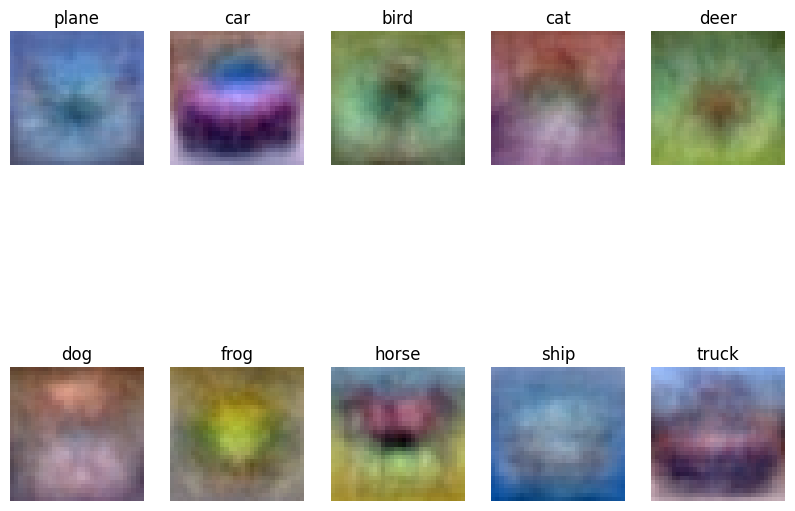

In [18]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])